---
title: "Bayesian Machine Learning and Julia are a match made in heaven"
author: "Sarem"
date: "2022-03-08"
categories: [Bayesian, Julia]
format:
  html:
    toc: true
    toc-location: left
    toc-depth: 2
    toc-title: Contents
description-meta: "Bayesian inference with less pain and even less code."
---

## Introduction
As I argued in an [earlier article](https://sarem-seitz.com/blog/when-is-bayesian-machine-learning-actually-useful/?ref=sarem-seitz.com), Bayesian Machine Learning can be quite powerful. Building actual Bayesian models in Python, however, is sometimes a bit of a hassle. Most solutions that you will find online are either [relatively complex](https://keras.io/examples/keras_recipes/bayesian_neural_networks/?ref=sarem-seitz.com) or require learning yet [another domain specific language](https://towardsdatascience.com/blitz-a-bayesian-neural-network-library-for-pytorch-82f9998916c7?ref=sarem-seitz.com). The latter could easily constrain your expressiveness when you need a highly customized solution.

Doing Bayesian Machine Learning in Julia, on the other hand, allows you to mitigate both these issues. In fact, you just need a few lines of raw Julia code to build, for example, a [Bayesian Neural Network](https://arxiv.org/pdf/2007.06823.pdf?ref=sarem-seitz.com) for regression. Julia's [Flux](https://fluxml.ai/Flux.jl/stable/?ref=sarem-seitz.com) and [Turing](https://turing.ml/stable/?ref=sarem-seitz.com) packages will then handle the heavy workload under the hood.

Hence today, I want to show you how to implement and train a Bayesian Neural Network in less than 30 lines of Julia. Before showing you the code, let us briefly recall the main theoretical aspects:

## Bayesian Machine Learning in three steps
As always, we want to find a posterior distribution via Bayes' law:
$$
p(\theta \mid D)=\frac{p(D \mid \theta) p(\theta)}{p(D)}
$$
As the data term in the denominator is a constant, we can simplify the above:
$$
p(\theta \mid D) \propto p(D \mid \theta) p(\theta)
$$
To avoid confusion, let us use the following standard wording:
$$
\begin{gathered}
p(\theta):=\text { 'prior distribution' } \\
p(D \mid \theta):=\text { 'likelihood function' }
\end{gathered}
$$
For Bayesian Neural Network regression, we further specify the likelihood function:
$$
p(D \mid \theta)=\prod_{i=1}^N \mathcal{N}\left(y_i \mid f_W\left(X_i\right), \sigma^2\right)
$$
This denotes a product of independent normal distributions with means defined by the outputs of a Neural Network. The variance of the Normal distribution is chosen to be a constant.

The corresponding prior distribution could look as follows:
$$
p(\theta)=p(W, \sigma)=\prod_{k=1}^K \mathcal{N}\left(W_k \mid 0,1\right) \cdot \Gamma(1,1)
$$
The priors for $K$ network weights are independent standard normal distributions. For the square root of the variance (a.k.a. standard deviation), we use a standard Gamma distribution. So, from a theory perspective, we are all set up and ready to go.

Ideally, we now want to implement the Bayesian Neural Network in the following steps:

1. **Define the likelihood function**
2. **Define the prior distribution**
3. **Train the model**

Having these three steps separate from each other in the code, will help us to

- **Maintain readability** - Besides the corresponding functions being smaller, a potential reader can also easier discern the likelihood from the prior.
- **Keep the code testable at a granular level** - Likelihood and prior distribution are clearly separate concerns. Thus, we should also be able to test them individually.

With this in mind, let us start building the model in Julia.

## Defining the likelihood function
The `Flux` library provides everything we need to build and work with Neural Networks. It has `Dense` to build feedforward layers and `Chain` to combine the layers into a network.

Our `Likelihood` struct therefore consists of the Neural Network, `network`, and the standard deviation, `sigma`. In the feedforward pass, we use the network's output and `sigma` to define conditional mean and standard deviation of the Gaussian likelihood:

In [1]:
using Flux, Distributions

struct Likelihood
    network
    sigma
end
Flux.@functor Likelihood #tell Flux to look for trainable parameters in Likelihood

(p::Likelihood)(x) = Normal.(p.network(x)[:], p.sigma[1]); #Flux only recognizes Matrix parameters but Normal() needs a scalar for sigma


The dot in `Normal.(...)` lets us define one Normal distribution per network output, each with standard deviation `sigma`. We could combine this with `logpdf(...)` from the [Distributions](https://juliastats.org/Distributions.jl/stable/?ref=sarem-seitz.com) library in order to train the model with maximum likelihood gradient descent. To perform Bayesian Machine Learning, however, we need to add a few more elements.

This leads us to the central function of this article, namely `Flux.destructure()`. From the documentation:

In [2]:
@doc Flux.destructure

```
destructure(model) -> vector, reconstructor
```

Copies all [`trainable`](@ref), [`isnumeric`](@ref) parameters in the model to a vector, and returns also a function which reverses this transformation. Differentiable.

# Example

```jldoctest
julia> v, re = destructure((x=[1.0, 2.0], y=(sin, [3.0 + 4.0im])))
(ComplexF64[1.0 + 0.0im, 2.0 + 0.0im, 3.0 + 4.0im], Restructure(NamedTuple, ..., 3))

julia> re([3, 5, 7+11im])
(x = [3.0, 5.0], y = (sin, ComplexF64[7.0 + 11.0im]))
```

If `model` contains various number types, they are promoted to make `vector`, and are usually restored by `Restructure`. Such restoration follows the rules  of `ChainRulesCore.ProjectTo`, and thus will restore floating point precision, but will permit more exotic numbers like `ForwardDiff.Dual`.

If `model` contains only GPU arrays, then `vector` will also live on the GPU. At present, a mixture of GPU and ordinary CPU arrays is undefined behaviour.


In summary, `destructure(...)` takes an instantiated model struct and returns a tuple with two elements:

1. The **model parameters**, concatenated into a single vector
2. A **reconstructor function** that takes a parameter vector as in 1. as input and returns the model with those parameters

The latter is important as we can feed an arbitrary parameter vector to the reconstructor. As long as its length is valid, it returns the corresponding model with the given parameter configuration. In code:

In [3]:
likelihood = Likelihood(Chain(Dense(1,5,tanh),Dense(5,1)), ones(1,1))

params, likelihood_reconstructor = Flux.destructure(likelihood)
n_weights = length(params) - 1

likelihood_conditional(weights, sigma) = likelihood_reconstructor(vcat(weights...,sigma));

The last function will allow us to provide weights and standard deviation parameters separately to the reconstructor. This is a necessary step in order for `Turing` to handle the Bayesian inference part.

From here, we are ready to move to the prior distribution.

## Defining the prior distribution
This part is very short - we only need to define the prior distributions for the weight vector and the standard deviation scalar:

In [4]:
weight_prior = MvNormal(zeros(n_weights), ones(n_weights))
sigma_prior = Gamma(1.,1.);

Having defined both likelihood and prior, we can take samples from the **prior predictive distribution**,

$$
p(y \mid X)=\prod_{i=1}^N \int \mathcal{N}\left(y_i \mid f_W\left(X_i\right), \sigma^2\right) p(W) p(\sigma) d W d \sigma
$$

While this might look complicated as a formula, we are basically just drawing Monte Carlo samples. The prior predictive distribution itself includes the noise from sigma. Prior predictive draws from the network alone, i.e. the prior predictive mean, yield nice and smooth samples:

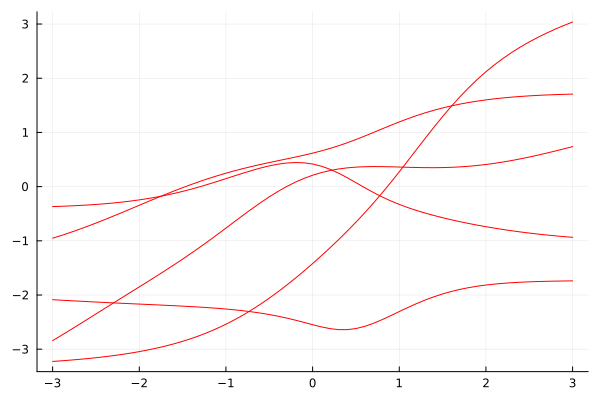

In [5]:
Xline = Matrix(transpose(collect(-3:0.1:3)[:,:]))
likelihood_conditional(rand(weight_prior), rand(sigma_prior))(Xline)

using Random, Plots
Random.seed!(54321)
plot(Xline[:],mean.(likelihood_conditional(rand(weight_prior), rand(sigma_prior))(Xline)),color=:red, legend=:none, fmt=:png)
plot!(Xline[:],mean.(likelihood_conditional(rand(weight_prior), rand(sigma_prior))(Xline)),color=:red)
plot!(Xline[:],mean.(likelihood_conditional(rand(weight_prior), rand(sigma_prior))(Xline)),color=:red)
plot!(Xline[:],mean.(likelihood_conditional(rand(weight_prior), rand(sigma_prior))(Xline)),color=:red)
plot!(Xline[:],mean.(likelihood_conditional(rand(weight_prior), rand(sigma_prior))(Xline)),color=:red)

Now, we can actually train the model.

## Training the Bayesian Neural Network
For this example, we'll be using synthetic data, sampled from
$$
p(y, X)=\prod_{i=1}^{50} \mathcal{N}\left(y_i \mid \sin \left(X_i\right), 0.25^2\right) \cdot \mathcal{U}\left(X_i \mid-2,2\right)
$$
The latter factor denotes a uniform density over $(-2,2)$.

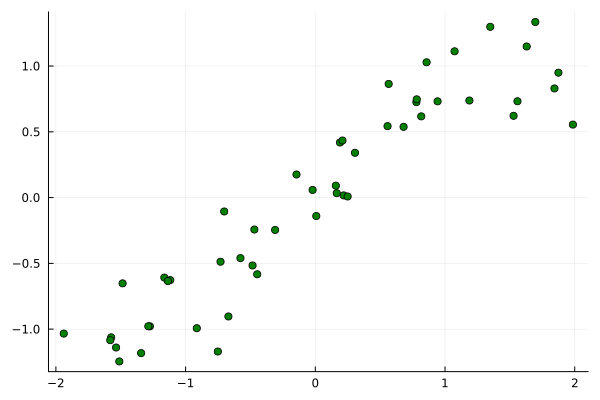

In [6]:
Random.seed!(54321)
X = rand(1,50) .* 4 .- 2
y = sin.(X) .+ randn(1,50).*0.25

scatter(X[:], y[:],color=:green,legend=:none, fmt=:png)

In order to use `Turing`, we need to define a model as [explained in their documentation](https://turing.ml/dev/docs/using-turing/quick-start?ref=sarem-seitz.com). Applied on our example, we get the following:

In [7]:
using Turing

@model function TuringModel(likelihood_conditional, weight_prior, sigma_prior, X, y)
    weights ~ weight_prior
    sigma ~ sigma_prior

    predictions = likelihood_conditional(weights,sigma)(X)
    
    y[:] ~ Product(predictions)
end;

Finally, we need to choose an algorithm for Bayesian posterior inference. As our model is comparatively small, [Hamiltonian Monte Carlo](https://en.wikipedia.org/wiki/Hamiltonian_Monte_Carlo?ref=sarem-seitz.com) (HMC) is a suitable choice. In fact, HMC is generally considered the gold standard algorithm for Bayesian Machine Learning. Unfortunately, it becomes quite inefficient in high dimensions.

Nevertheless, we now use HMC via Turing and collect the resulting draws from the MCMC posterior:

In [8]:
using Random

Random.seed!(54321)
N = 5000
ch = sample(TuringModel(likelihood_conditional, weight_prior, sigma_prior, X , y), HMC(0.025, 4), N);


weights = Array(MCMCChains.group(ch, :weights).value) #get posterior MCMC samples for network weights
sigmas = Array(MCMCChains.group(ch, :sigma).value); #get posterior MCMC samples for standard deviation

Sampling: 100%|█████████████████████████████████████████| Time: 0:00:05


From here, we can visualize the full posterior predictive distribution,
$$
p\left(y^* \mid X^*, X, y\right)=\prod_{i=1}^{N^*} \mathcal{N}\left(y_i^* \mid f_W\left(X_i^*\right), \sigma^2\right) \cdot p(W, \sigma \mid X, y) d W d \sigma
$$
This is done in a similar fashion as for the prior predictive distribution (star-variables denote new inputs outside the training set). The only difference is that we now use the samples from the MCMC posterior distribution.

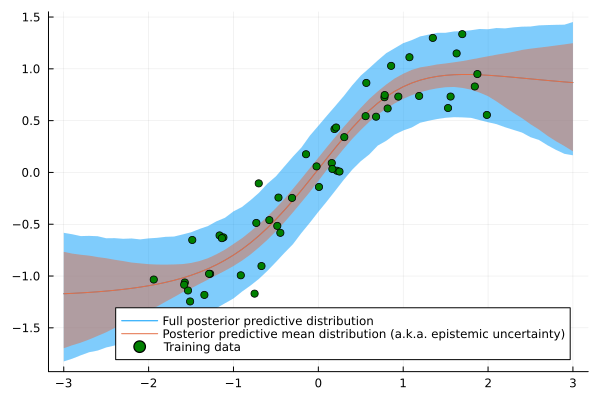

In [9]:
Random.seed!(54321)

posterior_predictive_mean_samples = []
posterior_predictive_full_samples = []

for _ in 1:10000
    samp = rand(1:5000,1)
    W = weights[samp,:,1]
    sigma = sigmas[samp,:,1]
    posterior_predictive_model = likelihood_reconstructor(vcat(W[:],sigma[:]))
    
    predictive_distribution = posterior_predictive_model(Xline)
    postpred_full_sample = rand(Product(predictive_distribution))
    push!(posterior_predictive_mean_samples,mean.(predictive_distribution))
    push!(posterior_predictive_full_samples, postpred_full_sample)
end

posterior_predictive_mean_samples = hcat(posterior_predictive_mean_samples...)

pp_mean = mean(posterior_predictive_mean_samples, dims=2)[:]
pp_mean_lower = mapslices(x -> quantile(x,0.05),posterior_predictive_mean_samples, dims=2)[:]
pp_mean_upper = mapslices(x -> quantile(x,0.95),posterior_predictive_mean_samples, dims=2)[:]

posterior_predictive_full_samples = hcat(posterior_predictive_full_samples...)
pp_full_lower = mapslices(x -> quantile(x,0.05),posterior_predictive_full_samples, dims=2)[:]
pp_full_upper = mapslices(x -> quantile(x,0.95),posterior_predictive_full_samples, dims=2)[:]

plot(Xline[:],pp_mean, ribbon = (pp_mean.-pp_full_lower, pp_full_upper.-pp_mean),legend=:bottomright, label="Full posterior predictive distribution", fmt=:png)
plot!(Xline[:], pp_mean, ribbon = (pp_mean.-pp_mean_lower, pp_mean_upper.-pp_mean), label="Posterior predictive mean distribution (a.k.a. epistemic uncertainty)")
scatter!(X[:],y[:],color=:green, label = "Training data")

Using the above example, it is easy to try out other prior distributions.

## Plug-and-play with different prior distributions
As another big advantage, `Turing` can use almost all distributions from the `Distributions` library as a prior. This also allows us to try out some exotic weight priors, say a [Semicircle distribution](https://juliastats.org/Distributions.jl/latest/univariate/?ref=sarem-seitz.com#Distributions.Semicircle) with radius 0.5. All we have to do is replace the Gaussian prior:

In [10]:
weight_prior = Product([Semicircle(0.5) for _ in 1:n_weights]);

With the same setup as before, we get the following posterior predictive distribution:

Sampling: 100%|█████████████████████████████████████████| Time: 0:00:05


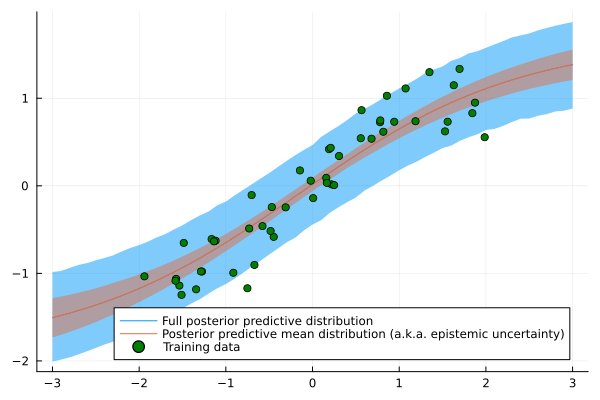

In [11]:
Random.seed!(54321)
N = 5000
ch = sample(TuringModel(likelihood_conditional, weight_prior, sigma_prior, X , y), HMC(0.025, 4), N);


weights = MCMCChains.group(ch, :weights).value #get posterior MCMC samples for network weights
sigmas = MCMCChains.group(ch, :sigma).value #get posterior MCMC samples for standard deviation


posterior_predictive_mean_samples = []
posterior_predictive_full_samples = []

for _ in 1:10000
    samp = rand(1:5000,1)
    W = weights[samp,:,1]
    sigma = sigmas[samp,:,1]
    posterior_predictive_model = likelihood_reconstructor(vcat(W[:],sigma[:]))
    
    predictive_distribution = posterior_predictive_model(Xline)
    postpred_full_sample = rand(Product(predictive_distribution))
    push!(posterior_predictive_mean_samples,mean.(predictive_distribution))
    push!(posterior_predictive_full_samples, postpred_full_sample)
end
    
posterior_predictive_mean_samples = hcat(posterior_predictive_mean_samples...)
pp_mean = mean(posterior_predictive_mean_samples, dims=2)[:]
pp_mean_lower = mapslices(x -> quantile(x,0.05),posterior_predictive_mean_samples, dims=2)[:]
pp_mean_upper = mapslices(x -> quantile(x,0.95),posterior_predictive_mean_samples, dims=2)[:]



posterior_predictive_full_samples = hcat(posterior_predictive_full_samples...)
pp_full_lower = mapslices(x -> quantile(x,0.05),posterior_predictive_full_samples, dims=2)[:]
pp_full_upper = mapslices(x -> quantile(x,0.95),posterior_predictive_full_samples, dims=2)[:]

plot(Xline[:],pp_mean, ribbon = (pp_mean.-pp_full_lower, pp_full_upper.-pp_mean),legend=:bottomright, label="Full posterior predictive distribution", fmt=:png)
plot!(Xline[:], pp_mean, ribbon = (pp_mean.-pp_mean_lower, pp_mean_upper.-pp_mean), label="Posterior predictive mean distribution (a.k.a. epistemic uncertainty)")
scatter!(X[:],y[:],color=:green, label = "Training data")

The possibilities obviously don't stop here. Another fruitful adjustment could be the introduction of [hyperprior distributions](https://en.wikipedia.org/wiki/Hyperprior?ref=sarem-seitz.com), e.g. over the standard deviation of the weight priors.

Using a model different from a Neural Network is also quite simple. You only need to adjust the Likelihood struct and corresponding functions.

## Conclusion
This article was a brief introduction to Bayesian Machine Learning with Julia. As matter of fact, [Julia is not just fast](Julia is not just fast) but can also make coding much easier and more efficient.

While Julia is still a young language with some caveats to deploying Julia programs to production, it is definitely an awesome language for research and prototyping. Especially the seamless interoperability between different libraries can considerably shorten iteration cycles both inside and outside of academia.

At this point, I am also quite hopeful that we will, at some point in the near future, see more Julia being used in industry-grade production code.

## References
**[1]** Bezanson, Jeff, et al. Julia: A fast dynamic language for technical computing. arXiv preprint arXiv:1209.5145, 2012.

**[2]** Ge, Hong; Xu, Kai; Ghahramani, Zoubin. Turing: a language for flexible probabilistic inference. In: International conference on artificial intelligence and statistics. PMLR, 2018. p. 1682-1690.